# BIM Production

We consider Caroline's material planning again, but now with more sophisticated pricing and acquisition protocols. 
There are now three suppliers. 
The suppliers can deliver the following materials:
 - A: **silicon**, **germanium** and **plastic**
 - B: **copper**
 - C: all of the above
Copper should be acquired in multiples of 100 gram, since it is delivered in sheets of 100 gram. 
Unitary materials such as silicon, germanium and plastic may be acquired in any number, but the price is in batches of 100. Meaning that 30 units of silicon with 10 units of germanium and 50 units of plastic cost as much as 1 unit of silicon but half as much as 30 units of silicon with 30 units of germanium and 50 units of plastic. 
Furthermore, supplier C sells all materials and offers a discount if purchased together: 100 gram of copper and a batch of unitary material cost just 7. This set price is only applied to pairs, meaning that 100 gram of copper and 2 batches cost 13.

The prices are as follows in &euro;:

|Supplier|Copper per sheet of 100 gram|Batch of units|Together|
|:-------|---------------------:|-----------------:|-------:|
| A      |                    - |                5 |      - |
| B      |                    3 |                - |      - |
| C      |                    4 |                6 |      7 |

When stocking materials, the inventory costs are as follows per month:

|Copper per 10 gram| Silicon per unit| Germanium per unit|Plastic per unit|
|---:|-------:|---:|-----:|
| 0.1|   0.02 |0.02| 0.02 |

The holding price of copper is per 10 gram and the copper stocked is rounded up to multiples of 10 grams, meaning that 12 grams pay for 20. 

The capacity limitations of the warehouse allow for a maximum of 10 kilogram of copper in stock at any moment.
There are no practical limitations to the number of units in stock.

As you recall, Caroline has the following stock at the moment:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 480|   1000 |1500| 1750 |

Caroline would like to have at least the following stock at the end of the year:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 200|    500 | 500| 1000 |

Please help her to model the material planning and solve it with the data above. 
Note that Caroline aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. 
The production is made to order, meaning that no inventory of chips is kept.


In [1]:
import sys
if 'google.colab' in sys.modules:
    import shutil
    if not shutil.which('pyomo'):
        !pip install -q pyomo
        assert(shutil.which('pyomo'))

    # cbc
    !apt-get install -y -qq coinor-cbc

To be self contained... alternative is to upload and read a file. 

In [2]:
demand_data = '''chip,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66'''

In [3]:
from io import StringIO
import pandas as pd
demand_chips = pd.read_csv( StringIO(demand_data), index_col='chip' )
demand_chips

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


In [4]:
use = dict()
use['Logic'] = { 'silicon' : 1, 'plastic' : 1, 'copper' : 4 }
use['Memory'] = { 'germanium' : 1, 'plastic' : 1, 'copper' : 2 }
use = pd.DataFrame.from_dict( use ).fillna(0).astype( int )
use

,Logic,Memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


In [5]:
demand = use.dot( demand_chips )
demand

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


In [6]:
def Table1d( m, J, retriever ):
    return pd.DataFrame( [ 0+retriever(m,j) for j in J ], index=J ).T.round(0).astype(int)

def Table2d( m, I, J, retriever ):
    return pd.DataFrame.from_records( [ [ 0+retriever( m, i, j ) for j in J ] for i in I ], index=I, columns=J ).round(0).astype(int)

def Table3d( m, I, J, names, K, retriever ):
    index = pd.MultiIndex.from_product( [I,J], names=names )
    return pd.DataFrame.from_records( [ [ 0+retriever(m,i,j,k) for k in K ] for i in I for j in J ],index=index,columns=K ).round(0).astype(int)

In [7]:
import pyomo.environ as pyo

In [8]:
def VersionOne( demand, existing, desired, stock_limit,
                supplying_copper, supplying_batches, 
                price_copper_sheet, price_batch, discounted_price, 
                batch_size, copper_sheet_mass, copper_bucket_size,
                unitary_products, unitary_holding_costs
                ):
    
    m = pyo.ConcreteModel( 'Product acquisition and inventory with sophisticated prices' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    @m.Param( products, periods )
    def delta(m,p,t):
        return demand.loc[p,t]
    
    @m.Param( supplying_batches )
    def pi(m,s):
        return price_batch[s]
    
    @m.Param( supplying_copper )
    def kappa(m,s):
        return price_copper_sheet[s]
    
    @m.Param()
    def beta(m):
        return price_batch['C']+price_copper_sheet['C']-discounted_price
    
    @m.Param(products)
    def gamma(m,p):
        return unitary_holding_costs[p]
    
    @m.Param( products )
    def Alpha(m,p):
        return existing[p]
    
    @m.Param( products )
    def Omega(m,p):
        return desired[p]
    
    m.y = pyo.Var( periods, supplying_copper, within=pyo.NonNegativeIntegers )
    m.x = pyo.Var( unitary_products, periods, supplying_batches, within=pyo.NonNegativeReals )
    m.s = pyo.Var( products, periods, within=pyo.NonNegativeReals )
    m.u = pyo.Var( products, periods, within=pyo.NonNegativeReals )
    m.b = pyo.Var( periods, supplying_batches, within=pyo.NonNegativeIntegers )
    m.p = pyo.Var( periods, within=pyo.NonNegativeIntegers )
    m.r = pyo.Var( periods, within=pyo.NonNegativeIntegers )

    @m.Constraint( periods, supplying_batches )
    def units_in_batches( m, t, s ):
        return pyo.quicksum( m.x[p,t,s] for p in unitary_products ) <= batch_size*m.b[t,s]
    
    @m.Constraint( periods )
    def copper_in_buckets( m, t ):
        return m.s['copper',t] <= copper_bucket_size*m.r[t]
    
    @m.Constraint( periods )
    def inventory_capacity( m, t ):
        return m.s['copper',t] <= stock_limit

    @m.Constraint( periods )
    def pairs_in_batches( m, t ):
        return m.p[t] <= m.b[t,'C']

    @m.Constraint( periods )
    def pairs_in_sheets( m, t ):
        return m.p[t] <= m.y[t,'C']
    
    @m.Constraint( periods, products )
    def bought( m, t, p ):
        if p == 'copper':
            return m.u[p,t] == copper_sheet_mass*pyo.quicksum( m.y[t,s] for s in supplying_copper )
        else:
            return m.u[p,t] == pyo.quicksum( m.x[p,t,s] for s in supplying_batches )
            
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( 
                    pyo.quicksum( m.pi[s]*m.b[t,s] for s in supplying_batches ) \
                  + pyo.quicksum( m.kappa[s]*m.y[t,s] for s in supplying_copper ) \
                  - m.beta * m.p[t] for t in periods )   
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.gamma['copper']*m.r[t] + \
                             pyo.quicksum( m.gamma[p]*m.s[p,t] for p in unitary_products ) \
                            for t in periods )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint( products, periods )
    def balance( m, p, t ):
        if t == first:
            return m.Alpha[p] + m.u[p,t] == m.delta[p,t] + m.s[p,t]
        else:
            return m.u[p,t] + m.s[p,prev[t]] == m.delta[p,t] + m.s[p,t]
        
    @m.Constraint( products )
    def finish( m, p ):
        return m.s[p,last] >= m.Omega[p]
    
    return m

In [48]:
m1 = VersionOne( demand = demand, 
    existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
    desired = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 }, 
    stock_limit = 10000,
    supplying_copper = [ 'B', 'C' ],
    supplying_batches = [ 'A', 'C' ],
    price_copper_sheet = { 'B': 300, 'C': 400 }, 
    price_batch = { 'A': 500, 'C': 600 }, 
    discounted_price = 700, 
    batch_size = 100,
    copper_sheet_mass = 100,
    copper_bucket_size = 10,
    unitary_products = [ 'silicon', 'germanium', 'plastic' ], 
    unitary_holding_costs = { 'copper': 10, 'silicon' : 2, 'germanium': 2, 'plastic': 2 }
    )

pyo.SolverFactory( 'cbc' ).solve(m1)

{'Problem': [{'Name': 'unknown', 'Lower bound': 110216.0, 'Upper bound': 110216.0, 'Number of objectives': 1, 'Number of constraints': 86, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 72, 'Number of nonzeros': 130, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 36.92, 'Wallclock time': 36.92, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 366868, 'Number of created subproblems': 366868}, 'Black box': {'Number of iterations': 1026438}}, 'Error rc': 0, 'Time': 37.145559310913086}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [49]:
stock = Table2d( m1, demand.index, demand.columns, lambda m,i,j : pyo.value(m.s[i,j]) )
stock.style.format('{:.0f}').to_latex('ch3stock.tex')

In [50]:
stock.to_csv('stock1.csv')

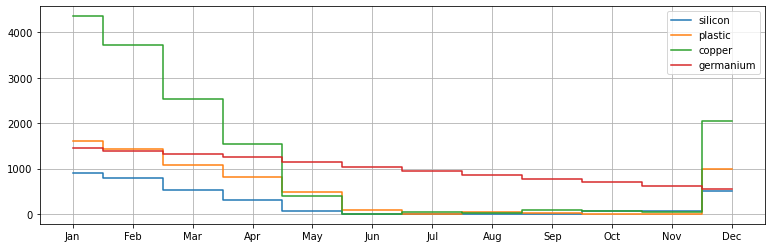

In [51]:
import matplotlib.pyplot as plt, numpy as np
stock.T.plot(drawstyle='steps-mid',grid=True, figsize=(13,4))
plt.xticks(np.arange(len(stock.columns)),stock.columns)
plt.savefig('ch3stock.pdf', bbox_inches="tight", pad_inches=0,dpi=2400)

In [35]:
pairs=Table1d( m1, J = demand.columns, retriever = lambda m, j : pyo.value( m.p[j] ) )
pairs.style.format('{:.0f}').to_latex('ch3pair.tex')

In [36]:
pairs

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,3,5,6,6,7,6,20


In [ ]:
pairs.to_csv('pairs1.csv')

In [12]:
Table2d( m1, demand.index, demand.columns, lambda m,i,j : pyo.value(m.u[i,j]) ).to_csv('buy1.csv')

In [34]:
batch = Table2d( m1, [ 'A', 'C' ], demand.columns, lambda m,i,j : pyo.value(m.b[j,i]) )
batch.style.format('{:.0f}').to_latex('ch3batch.tex')

In [ ]:
batch.to_csv('batches1.csv')

In [32]:
y = Table2d( m1, [ 'B', 'C' ], demand.columns, lambda m,i,j : pyo.value(m.y[j,i]) )
y.style.format('{:.0f}').to_latex('ch3sheets.tex')

In [31]:
y.to_csv('sheets1.csv')

In [27]:
x = Table3d( m1, 
        I        = [ 'A', 'C' ], 
        J        = [ 'silicon', 'germanium', 'plastic' ], 
        names    = ['supplier','materials'], 
        K        = demand.columns, 
        retriever= lambda m,i,j,k : 0+pyo.value( m.x[j,k,i] ) 
        )
x

Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  \
supplier materials                                                          
A        silicon      0    0    0    0    0    0    0    0    0    0    0   
         germanium    0    0    0    0    0    0    0    0    0    0    0   
         plastic      0    0    0    0    0    0    0    0    0    0    0   
C        silicon      0    0    0    0    0  214  249  237  265  349  257   
         germanium    0    0    0    0    0    0    0    0    0    0    0   
         plastic      0    0    0    0    0   15  251  363  335  351  343   

                     Dec  
supplier materials        
A        silicon       0  
         germanium     0  
         plastic       0  
C        silicon     690  
         germanium     0  
         plastic    1310

In [29]:
x.style.format('{:.0f}').to_latex('ch3buy.tex')

In [28]:
x.to_csv('unit1.csv')

In [16]:
def VersionTwo( demand, existing, desired, 
                stock_limit,
                supplying_copper, supplying_batches, price_copper_sheet, price_batch, discounted_price, 
                batch_size, copper_sheet_mass, copper_bucket_size,
                unitary_products, unitary_holding_costs
                ):
    m = pyo.ConcreteModel( 'Product acquisition and inventory with sophisticated prices in blocks' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    
    m.PT = m.P * m.T # to avoid internal set bloat
    
    @m.Block( m.T )
    def A( b ):
        b.x = pyo.Var( supplying_batches, products, within=pyo.NonNegativeReals )
        b.b = pyo.Var( supplying_batches, within=pyo.NonNegativeIntegers )
        b.y = pyo.Var( supplying_copper, within=pyo.NonNegativeIntegers )
        b.p = pyo.Var( within=pyo.NonNegativeIntegers )

        @b.Constraint( supplying_batches )
        def in_batches( b, s ):
            return pyo.quicksum( b.x[s,p] for p in products ) <= batch_size*b.b[s]

        @b.Constraint()
        def pairs_in_batches( b ):
            return b.p <= b.b['C']

        @b.Constraint()
        def pairs_in_sheets( b ):
            return b.p <= b.y['C']
        
        @b.Expression( products )
        def u( b, p ):
            if p == 'copper':
                return copper_sheet_mass*pyo.quicksum( b.y[s] for s in supplying_copper )
            return pyo.quicksum( b.x[s,p] for s in supplying_batches )
            
        @b.Expression()
        def cost( b ):
            discount = price_batch['C']+price_copper_sheet['C']-discounted_price
            return pyo.quicksum( price_copper_sheet[s]*b.y[s] for s in supplying_copper ) \
                + pyo.quicksum( price_batch[s]*b.b[s] for s in supplying_batches ) \
                - discount * b.p    
    
    @m.Block( m.T )
    def I( b ):
        b.s = pyo.Var( products, within=pyo.NonNegativeReals )
        b.r = pyo.Var( within=pyo.NonNegativeIntegers )
        
        @b.Constraint()
        def copper_in_buckets(b):
            return b.s['copper'] <= copper_bucket_size*b.r
        
        @b.Constraint()
        def capacity( b ):
            return b.s['copper'] <= stock_limit

        @b.Expression()
        def cost( b ):
            return unitary_holding_costs['copper']*b.r + \
                pyo.quicksum( unitary_holding_costs[p]*b.s[p] for p in unitary_products )
            
    @m.Param( m.PT )
    def delta(m,t,p):
        return demand.loc[t,p]
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.A[t].cost for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.I[t].cost for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint( m.PT )
    def balance( m, p, t ):
        if t == first:
            return existing[p] + m.A[t].u[p] == m.delta[p,t] + m.I[t].s[p]
        else:
            return m.A[t].u[p] + m.I[prev[t]].s[p] == m.delta[p,t] + m.I[t].s[p]
        
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.I[last].s[p] >= desired[p]
    
    return m

In [52]:
m2 = VersionTwo( demand = demand, 
    existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
    desired = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 }, 
    stock_limit = 10000,
    supplying_copper = [ 'B', 'C' ],
    supplying_batches = [ 'A', 'C' ],
    price_copper_sheet = { 'B': 300, 'C': 400 }, 
    price_batch = { 'A': 500, 'C': 600 }, 
    discounted_price = 700, 
    batch_size = 100,
    copper_sheet_mass = 100,
    copper_bucket_size = 10,
    unitary_products = [ 'silicon', 'germanium', 'plastic' ], 
    unitary_holding_costs = { 'copper': 10, 'silicon' : 2, 'germanium': 2, 'plastic': 2 }
    )

pyo.SolverFactory( 'cbc' ).solve(m2)

{'Problem': [{'Name': 'unknown', 'Lower bound': 110216.0, 'Upper bound': 110216.0, 'Number of objectives': 1, 'Number of constraints': 86, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 72, 'Number of nonzeros': 130, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 22.02, 'Wallclock time': 22.02, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 164391, 'Number of created subproblems': 164391}, 'Black box': {'Number of iterations': 899086}}, 'Error rc': 0, 'Time': 22.223931312561035}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [18]:
Table3d( m2, 
        I        = [ 'A', 'C' ], 
        J        = [ 'silicon', 'germanium', 'plastic' ], 
        names    = ['supplier','materials'], 
        K        = m2.T, 
        retriever= lambda m,i,j,k : 0+pyo.value( m.A[k].x[i,j] ) 
        ).to_csv('unit2.csv')


In [19]:
def VersionThree( demand, existing, desired, 
                stock_limit,
                supplying_copper, supplying_batches, price_copper_sheet, price_batch, discounted_price, 
                batch_size, copper_sheet_mass, copper_bucket_size,
                unitary_products, unitary_holding_costs
                ):
    m = pyo.ConcreteModel( 'Product acquisition and inventory with sophisticated prices' )
    
    periods  = demand.columns
    products = demand.index 
    first    = periods[0] 
    prev     = { j : i for i,j in zip(periods,periods[1:]) }
    last     = periods[-1]
    
    m.T = pyo.Set( initialize=periods )
    m.P = pyo.Set( initialize=products )
    
    m.PT = m.P * m.T # to avoid internal set bloat
    
    m.x = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    m.s = pyo.Var( m.PT, within=pyo.NonNegativeReals )
    
    @m.Block( m.T )
    def acquisition( b ):
        b.units  = pyo.Var( supplying_batches, products, within=pyo.NonNegativeReals )
        b.batches= pyo.Var( supplying_batches, within=pyo.NonNegativeIntegers )
        b.sheets = pyo.Var( supplying_copper, within=pyo.NonNegativeIntegers )
        b.pairs  = pyo.Var( within=pyo.NonNegativeIntegers )

        @b.Constraint( supplying_batches )
        def in_batches( b, s ):
            return pyo.quicksum( b.units[s,p] for p in products ) <= batch_size*b.batches[s]

        @b.Constraint()
        def pairs_in_batches( b ):
            return b.pairs <= b.batches['C']

        @b.Constraint()
        def pairs_in_sheets( b ):
            return b.pairs <= b.sheets['C']
        
        @b.Expression( products )
        def x( b, p ):
            if p == 'copper':
                return copper_sheet_mass*pyo.quicksum( b.sheets[s] for s in supplying_copper )
            return pyo.quicksum( b.units[s,p] for s in supplying_batches )
            
        @b.Expression()
        def cost( b ):
            discount = price_batch['C']+price_copper_sheet['C']-discounted_price
            return pyo.quicksum( price_copper_sheet[s]*b.sheets[s] for s in supplying_copper ) \
                + pyo.quicksum( price_batch[s]*b.batches[s] for s in supplying_batches ) \
                - discount * b.pairs    
    
    @m.Block( m.T )
    def inventory( b ):
        b.s       = pyo.Var( products, within=pyo.NonNegativeReals )
        b.buckets = pyo.Var( within=pyo.NonNegativeIntegers )
        
        @b.Constraint()
        def copper_in_buckets(b):
            return b.s['copper'] <= copper_bucket_size*b.buckets
        
        @b.Constraint()
        def capacity( b ):
            return b.s['copper'] <= stock_limit

        @b.Expression()
        def cost( b ):
            return unitary_holding_costs['copper']*b.buckets + \
                pyo.quicksum( unitary_holding_costs[p]*b.s[p] for p in unitary_products )
            
    @m.Param( m.PT )
    def delta(m,t,p):
        return demand.loc[t,p]
    
    @m.Expression()
    def acquisition_cost( m ):
        return pyo.quicksum( m.acquisition[t].cost for t in m.T )
    
    @m.Expression()
    def inventory_cost( m ):
        return pyo.quicksum( m.inventory[t].cost for t in m.T )
    
    @m.Objective( sense=pyo.minimize )
    def total_cost( m ):
        return m.acquisition_cost + m.inventory_cost
    
    @m.Constraint( m.PT )
    def match_x( m, p, t ):
        m.x[p,t] == m.A[t].x[p]
    
    @m.Constraint( m.PT )
    def match_s( m, p, t ):
        m.s[p,t] == m.I[t].s[p]
        
    @m.Constraint( m.PT )
    def balance( m, p, t ):
        if t == first:
            return existing[p] + m.x[p,t] == m.delta[p,t] + m.s[p,t]
        else:
            return m.x[p,t] + m.s[p,prev[t]] == m.delta[p,t] + m.s[p,t]
        
    @m.Constraint( m.P )
    def finish( m, p ):
        return m.inventory[last].s[p] >= desired[p]
    
    return m

In [53]:
m3 = VersionThree( demand = demand, 
    existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800 }, 
    desired = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000 }, 
    stock_limit = 10000,
    supplying_copper = [ 'B', 'C' ],
    supplying_batches = [ 'A', 'C' ],
    price_copper_sheet = { 'B': 300, 'C': 400 }, 
    price_batch = { 'A': 500, 'C': 600 }, 
    discounted_price = 700, 
    batch_size = 100,
    copper_sheet_mass = 100,
    copper_bucket_size = 10,
    unitary_products = [ 'silicon', 'germanium', 'plastic' ], 
    unitary_holding_costs = { 'copper': 10, 'silicon' : 2, 'germanium': 2, 'plastic': 2 }
    )

pyo.SolverFactory( 'cbc' ).solve(m3)

{'Problem': [{'Name': 'unknown', 'Lower bound': 110216.0, 'Upper bound': 110216.0, 'Number of objectives': 1, 'Number of constraints': 86, 'Number of variables': 170, 'Number of binary variables': 0, 'Number of integer variables': 72, 'Number of nonzeros': 130, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 22.25, 'Wallclock time': 22.25, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 164391, 'Number of created subproblems': 164391}, 'Black box': {'Number of iterations': 899086}}, 'Error rc': 0, 'Time': 22.467795848846436}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [21]:
Table1d( m3, J = m3.T, retriever = lambda m, j : pyo.value( m.acquisition[j].pairs ) ).to_csv('pairs3.csv')

In [22]:
Table2d( m3, I=m3.P, J=m3.T, retriever = lambda m, i, j : pyo.value( 0+m.acquisition[j].x[i] ) ).to_csv('buy3.csv')

In [23]:
Table2d( m3, I=['B','C'], J=m3.T, retriever = lambda m, i, j : pyo.value( 0+m.acquisition[j].sheets[i] ) ).to_csv('sheets3.csv')

In [24]:
Table2d( m3, I=m3.P, J=m3.T, retriever = lambda m, i, j : pyo.value( m.inventory[j].s[i] ) ).to_csv('stock3.csv')

In [25]:
Table2d( m3, I=['A','C'], J=m3.T, retriever=lambda m, i, j : pyo.value( m.acquisition[j].batches[i] ) ).to_csv('batches3.csv')

In [26]:
Table3d( m3, 
        I        = [ 'A', 'C' ], 
        J        = [ 'silicon', 'germanium', 'plastic' ], 
        names    = ['supplier','materials'], 
        K        = m3.T, 
        retriever= lambda m,i,j,k : 0+pyo.value( m.acquisition[k].units[i,j] ) 
        ).to_csv('unit3.csv')
